# Vol

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib
import pandas as pd
from tensorflow import keras
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas_datareader.data as web
from datetime import datetime
import yfinance as yf

/Users/georgedrimba/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/georgedrimba/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/georgedrimba/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/georgedrimba/anaconda3/lib/python3.7/site-packages/ten

In [2]:
#remote
#df = web.get_data_yahoo('NVDA',start=datetime(1970, 1, 1))
df = yf.download(['LOW'], period = 'Max', interval = '1d', group_by = 'ticker',
                   auto_adjust = False,prepost = True,threads = True, proxy = None )
df = df.iloc[::-1]
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-03-21,0.0,0.457031,0.445312,0.445312,0.003566,348800
1980-03-20,0.0,0.460938,0.453125,0.453125,0.003629,2105600
1980-03-19,0.0,0.457031,0.449219,0.453125,0.003629,777600
1980-03-18,0.0,0.468750,0.453125,0.453125,0.003629,272000
1980-03-17,0.0,0.476562,0.464844,0.464844,0.003723,217600


In [3]:
ticks = pd.read_csv('ticks.csv', header=None)
ticks = list(ticks[0])
sym = ticks[:100]

FileNotFoundError: [Errno 2] File ticks.csv does not exist: 'ticks.csv'

In [4]:
#df_dict ={}
#for x in sym:
#    df_dict[x] = web.get_data_yahoo(x,start=datetime(1970, 1, 1))
#data = pd.DataFrame(df_dict)
#data
#result = list(map(lambda x, y: x + y, ['df_']*len(sym), sym))
#link = dict(list(zip(sym,result)))

In [5]:
def data_prep(df):
    df2 = df.copy()
    df2["Adj Open"] = (df2["Adj Close"]/df2["Close"] * df2["Open"])
    df2["Adj High"] = (df2["Adj Close"]/df2["Close"] * df2["High"])
    df2["Adj Low"] = (df2["Adj Close"]/df2["Close"] * df2["Low"])
    df2["Log HO"] = np.log(df2["Adj High"]/df2["Adj Open"])
    df2["Log LO"] = np.log(df2["Adj Low"]/df2["Adj Open"])
    df2["Log CO"] = np.log(df2["Adj Close"]/df2["Adj Open"])
    df2["Log OC"] = np.log(df2["Adj Open"]/df2.shift(-1)["Adj Close"])
    df2["Log OC^2"] = df2["Log OC"]**2
    df2["Log CC"] = np.log(df2["Close"]/df2.shift(-1)["Close"])
    df2["RS"] = (df2["Log HO"]*(df2["Log HO"]- df2["Log CO"])) + (df2["Log LO"]*(df2["Log LO"]- df2["Log CO"]))
    df2["LogCCC"] = df2["Log CC"]**2
    df2["Log HL"] = np.log(df2["Adj High"]/df2["Adj Low"])
    return df2

In [6]:
def yz_f(df):
    df2= data_prep(df)
    yz = pd.DataFrame(df2.iloc[:,0].copy())
    del yz["Open"]
    yz["30 day vol close"] = (1/29 )* df2["LogCCC"].rolling(window = 30).sum()
    yz["30 day vol close"] = yz.shift(-29)["30 day vol close"]
    yz["30 day vol open"] = (1/29 )* df2["Log OC^2"].rolling(window = 30).sum()
    yz["30 day vol open"] = yz.shift(-29)["30 day vol open"]
    yz["30 day vol RS"] = (1/29 )* df2["RS"].rolling(window = 30).sum()
    yz["30 day vol RS"] = yz.shift(-29)["30 day vol RS"]
    tmp = yz["30 day vol RS"].last_valid_index()
    yz.loc[tmp,"30 day vol RS"] = np.NaN
    yz["30 Day Yang Zhang"] = np.sqrt(252)*np.sqrt(yz["30 day vol open"] + 0.164333* yz["30 day vol close"]+ yz["30 day vol RS"]*0.835667)


    yz["60 day vol close"] = (1/59 )* df2["LogCCC"].rolling(window = 60).sum()
    yz["60 day vol close"] = yz.shift(-59)["60 day vol close"]
    yz["60 day vol open"] = (1/59 )* df2["Log OC^2"].rolling(window = 60).sum()
    yz["60 day vol open"] = yz.shift(-59)["60 day vol open"]
    yz["60 day vol RS"] = (1/59 )* df2["RS"].rolling(window = 60).sum()
    yz["60 day vol RS"] = yz.shift(-59)["60 day vol RS"]
    yz["60 Day Yang Zhang"] = np.sqrt(252)*np.sqrt(yz["60 day vol open"] + 0.167167* yz["60 day vol close"]+ yz["60 day vol RS"]*0.832833)


    yz["90 day vol close"] = (1/89 )* df2["LogCCC"].rolling(window = 90).sum()
    yz["90 day vol close"] = yz.shift(-89)["90 day vol close"]
    yz["90 day vol open"] = (1/89 )* df2["Log OC^2"].rolling(window = 90).sum()
    yz["90 day vol open"] = yz.shift(-89)["90 day vol open"]
    yz["90 day vol RS"] = (1/89 )* df2["RS"].rolling(window = 90).sum()
    yz["90 day vol RS"] = yz.shift(-89)["90 day vol RS"]
    yz["90 Day Yang Zhang"] = np.sqrt(252)*np.sqrt(yz["90 day vol open"] + 0.168111* yz["90 day vol close"]+ yz["90 day vol RS"]*0.831889)


    yz["120 day vol close"] = (1/119 )* df2["LogCCC"].rolling(window = 120).sum()
    yz["120 day vol close"] = yz.shift(-119)["120 day vol close"]
    yz["120 day vol open"] = (1/119 )* df2["Log OC^2"].rolling(window = 120).sum()
    yz["120 day vol open"] = yz.shift(-119)["120 day vol open"]
    yz["120 day vol RS"] = (1/119 )* df2["RS"].rolling(window = 120).sum()
    yz["120 day vol RS"] = yz.shift(-119)["120 day vol RS"]
    yz["120 Day Yang Zhang"] = np.sqrt(252)*np.sqrt(yz["120 day vol open"] + 0.168583* yz["120 day vol close"]+ yz["120 day vol RS"]*0.831417)
    return yz

In [7]:
def pk_f(df):
    df2= data_prep(df)
    pk = pd.DataFrame(df2.iloc[:,0].copy())
    del pk["Open"]
    pk["temp"]= (1/(4*np.log(2)))*np.log(df2["Adj High"]/df2["Adj Low"])**2
    pk["30 day vol"] =  np.sqrt(252* pk["temp"].rolling(window = 30).mean()).shift(-29)
    pk["60 day vol"] =  np.sqrt(252* pk["temp"].rolling(window = 60).mean()).shift(-59)
    pk["90 day vol"] =  np.sqrt(252* pk["temp"].rolling(window = 90).mean()).shift(-89)
    pk["120 day vol"] =  np.sqrt(252* pk["temp"].rolling(window = 120).mean()).shift(-119)
    return pk

In [8]:
def gk_f(df):
    df2= data_prep(df)
    gk = pd.DataFrame(df2.iloc[:,0].copy())
    del gk["Open"]
    gk["temp"]= (df2["Log OC"]**2 + 0.5*df2["Log HL"]**2 - 0.3862*df2["Log CO"]**2)
    gk["30 day vol"] =   np.sqrt(252* gk["temp"].rolling(window = 30).mean()).shift(-29)
    gk["60 day vol"] =  np.sqrt(252* gk["temp"].rolling(window = 60).mean()).shift(-59)
    gk["90 day vol"] =  np.sqrt(252* gk["temp"].rolling(window = 90).mean()).shift(-89)
    gk["120 day vol"] =  np.sqrt(252* gk["temp"].rolling(window = 120).mean()).shift(-119)
    return gk

In [9]:
def rs_f(df):
    df2= data_prep(df)
    rs = pd.DataFrame(df2.iloc[:,0].copy())
    del rs["Open"]
    rs["temp"]= (df2["RS"])
    rs["30 day vol"] =  np.sqrt(252* rs["temp"].rolling(window = 30).mean()).shift(-29)
    rs["60 day vol"] =  np.sqrt(252* rs["temp"].rolling(window = 60).mean()).shift(-59)
    rs["90 day vol"] =  np.sqrt(252* rs["temp"].rolling(window = 90).mean()).shift(-89)
    rs["120 day vol"] =  np.sqrt(252* rs["temp"].rolling(window = 120).mean()).shift(-119)
    return rs

In [10]:
def ht_f(df):
    df2= data_prep(df)
    ht = pd.DataFrame(df2.iloc[:,0].copy())
    del ht["Open"]
    ht["log return"] = np.log(df2["Adj Close"]/df2["Adj Close"].shift(-1))
    ht["30 day vol tmp"] =  np.sqrt(252)* ((ht["log return"].rolling(window = 30).std()).shift(-29))
    ht["60 day vol tmp"] =  np.sqrt(252)* ((ht["log return"].rolling(window = 60).std()).shift(-59))
    ht["90 day vol tmp"] =  np.sqrt(252)* ((ht["log return"].rolling(window = 90).std()).shift(-89))
    ht["120 day vol tmp"] =  np.sqrt(252)*(( ht["log return"].rolling(window = 120).std()).shift(-119))
    one_month = np.sqrt(1/(1 - (30/(ht["log return"].count()-29)) + ((30**2-1)/(3*(ht["log return"].count()-29)**2))))
    two_month = np.sqrt(1/(1 - (60/(ht["log return"].count()-59)) + ((60**2-1)/(3*(ht["log return"].count()-59)**2))))
    three_month = np.sqrt(1/(1 - (90/(ht["log return"].count()-89)) + ((90**2-1)/(3*(ht["log return"].count()-89)**2))))
    four_month = np.sqrt(1/(1 - (120/(ht["log return"].count()-119)) + ((120**2-1)/(3*(ht["log return"].count()-119)**2))))
    ht["30 day vol"] = ht["30 day vol tmp"]* one_month
    ht["60 day vol"] = ht["60 day vol tmp"]* two_month
    ht["90 day vol"] = ht["90 day vol tmp"]* three_month
    ht["120 day vol"] = ht["120 day vol tmp"]* four_month 
    return ht


In [11]:
def garch(df):
    df2 = data_prep(df)
    import warnings
    warnings.simplefilter('ignore')

    gh = pd.DataFrame(df2.iloc[:,0].copy())
    #del gh["High"]
    gh["log return"] = np.log(df2["Adj Close"]/df2["Adj Close"].shift(-1))
    returns = gh['log return'][::-1][1:]

    from arch import arch_model
    am = arch_model(returns, vol='Garch', p=1, o=0, q=1, dist='Normal')
    res = am.fit(update_freq=5)
    g_res = [gh,res]
    return g_res 

In [12]:
res = garch(df)[1]
gh = garch(df)[0]
gh['vol'] =np.sqrt(252) * (np.sqrt(res.params['omega'] + res.params['alpha[1]'] * res.resid**2 + res.conditional_volatility**2 * res.params['beta[1]']))
gh = gh[['vol']]
gh.head()

/Users/georgedrimba/venv/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -23862.502991614725
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


/Users/georgedrimba/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/georgedrimba/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:577: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -23862.502991614725
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


,vol
Date,
2020-09-28,0.327011
2020-09-25,0.323681
2020-09-24,0.333360
2020-09-23,0.346234
2020-09-22,0.344827


In [13]:
def table_create(df):
    ht = ht_f(df)
    rs = rs_f(df)
    yz = yz_f(df)
    gk = gk_f(df)
    pk = pk_f(df)
    
    ht_cones = ht.copy()
    ht_cones = ht_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    ht_maxi =ht_cones.quantile(1)
    ht_quartile_3 =ht_cones.quantile(.75)
    ht_median = ht_cones.quantile()
    ht_quartile_1 =ht_cones.quantile(.25)
    ht_mini =ht_cones.quantile(0)
    ht_report = pd.DataFrame([ht_maxi, ht_quartile_3, ht_median, ht_quartile_1, ht_mini], index=["Max","Q3","Median","Q2","Min"])
    print("Hodge-Tompkins:")
    display(ht_report)
    print("----------------------------------------------------------")
    
    rs_cones = rs.copy()
    rs_cones = rs_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    rs_maxi =rs_cones.quantile(1)
    rs_quartile_3 =rs_cones.quantile(.75)
    rs_median = rs_cones.quantile()
    rs_quartile_1 =rs_cones.quantile(.25)
    rs_mini =rs_cones.quantile(0)
    rs_report = pd.DataFrame([rs_maxi, rs_quartile_3, rs_median, rs_quartile_1, rs_mini], index=["Max","Q3","Median","Q2","Min"])
    print("Rogers-Satchell:")
    display(rs_report)
    print("----------------------------------------------------------")
    
    gk_cones = gk.copy()
    gk_cones = gk_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    gk_maxi =gk_cones.quantile(1)
    gk_quartile_3 =gk_cones.quantile(.75)
    gk_median = gk_cones.quantile()
    gk_quartile_1 =gk_cones.quantile(.25)
    gk_mini =gk_cones.quantile(0)
    gk_report = pd.DataFrame([gk_maxi, gk_quartile_3, gk_median, gk_quartile_1, gk_mini], index=["Max","Q3","Median","Q2","Min"])
    print("Garman-Klass:")
    display(gk_report)
    print("----------------------------------------------------------")
    
    pk_cones = pk.copy()
    pk_cones = pk_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    pk_maxi =pk_cones.quantile(1)
    pk_quartile_3 =pk_cones.quantile(.75)
    pk_median = pk_cones.quantile()
    pk_quartile_1 =pk_cones.quantile(.25)
    pk_mini =pk_cones.quantile(0)
    pk_report = pd.DataFrame([pk_maxi, pk_quartile_3, pk_median, pk_quartile_1, pk_mini], index=["Max","Q3","Median","Q2","Min"])
    print("Parkinson:")
    display(pk_report)
    print("----------------------------------------------------------")
    yz_cones = yz.copy()
    yz_cones = yz_cones[["30 Day Yang Zhang","60 Day Yang Zhang","90 Day Yang Zhang","120 Day Yang Zhang"]]
    yz_cones.columns =["30 day vol","60 day vol","90 day vol","120 day vol"]
    yz_maxi =yz_cones.quantile(1)
    yz_quartile_3 =yz_cones.quantile(.75)
    yz_median =yz_cones.quantile()
    yz_quartile_1 =yz_cones.quantile(.25)
    yz_mini =yz_cones.quantile(0)
    yz_report = pd.DataFrame([yz_maxi, yz_quartile_3, yz_median, yz_quartile_1, yz_mini], index=["Max","Q3","Median","Q2","Min"])
    print("Yang-Zhang:")
    display(yz_report)

In [14]:
table_create(df)

Hodge-Tompkins:


,30 day vol,60 day vol,90 day vol,120 day vol
Max,1.650920,1.201345,1.022186,0.907454
Q3,0.418873,0.429848,0.432648,0.443415
Median,0.316748,0.335184,0.341407,0.342278
Q2,0.233667,0.243351,0.247116,0.247460
Min,0.092978,0.130062,0.135188,0.148632


----------------------------------------------------------
Rogers-Satchell:


,30 day vol,60 day vol,90 day vol,120 day vol
Max,0.948840,0.880661,0.766956,0.710456
Q3,0.320484,0.319950,0.329556,0.333517
Median,0.247650,0.250891,0.255599,0.259524
Q2,0.196489,0.202144,0.207399,0.209961
Min,0.112779,0.120342,0.120425,0.126785


----------------------------------------------------------
Garman-Klass:


,30 day vol,60 day vol,90 day vol,120 day vol
Max,1.148625,0.949957,0.834054,0.771784
Q3,0.396442,0.401190,0.411494,0.430642
Median,0.296112,0.319991,0.319629,0.319334
Q2,0.232580,0.241060,0.247532,0.249672
Min,0.126061,0.143337,0.155137,0.165038


----------------------------------------------------------
Parkinson:


,30 day vol,60 day vol,90 day vol,120 day vol
Max,0.881330,0.829307,0.728043,0.678518
Q3,0.320310,0.321012,0.330051,0.334068
Median,0.252492,0.258964,0.262172,0.261717
Q2,0.196499,0.201768,0.206175,0.207997
Min,0.106121,0.120887,0.131880,0.136302


----------------------------------------------------------
Yang-Zhang:


,30 day vol,60 day vol,90 day vol,120 day vol
Max,1.243759,0.972273,0.850972,0.783648
Q3,0.418299,0.417627,0.423654,0.442975
Median,0.311508,0.332088,0.331121,0.332733
Q2,0.242806,0.248098,0.253429,0.256435
Min,0.124517,0.154799,0.158616,0.169680


In [15]:
def graph_create(df):
    ht = ht_f(df)
    rs = rs_f(df)
    yz = yz_f(df)
    gk = gk_f(df)
    pk = pk_f(df)
    
    ht_cones = ht.copy()
    ht_cones = ht_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
  
    rs_cones = rs.copy()
    rs_cones = rs_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    
    gk_cones = gk.copy()
    gk_cones = gk_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
  
    pk_cones = pk.copy()
    pk_cones = pk_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    
    yz_cones = yz.copy()
    yz_cones = yz_cones[["30 Day Yang Zhang","60 Day Yang Zhang","90 Day Yang Zhang","120 Day Yang Zhang"]]
    yz_cones.columns =["30 day vol","60 day vol","90 day vol","120 day vol"]
    
    ht_cones.plot(figsize=(15,6))
    plt.title("Hodge Tompkins")
    plt.show()
    rs_cones.plot(figsize=(15,6))
    plt.title("Rogers Satchell")
    plt.show()
    pk_cones.plot(figsize=(15,6))
    plt.title("Parkinson")
    plt.show()
    gk_cones.plot(figsize=(15,6))
    plt.title("Garman Klass volatility")
    plt.show()
    yz_cones.plot(figsize=(15,6))
    plt.title("Yang-Zhang")
    plt.show()

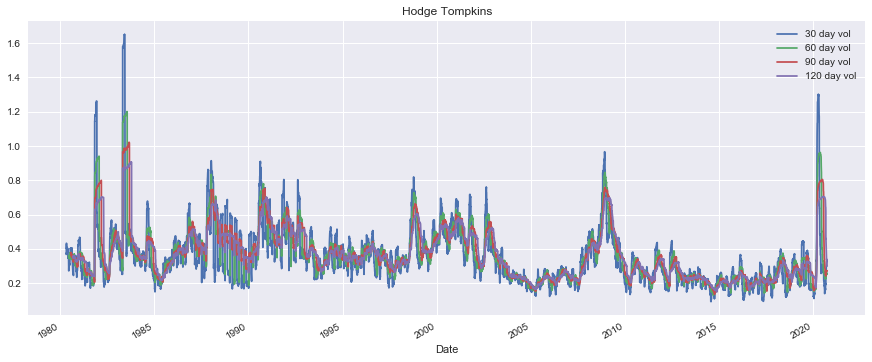

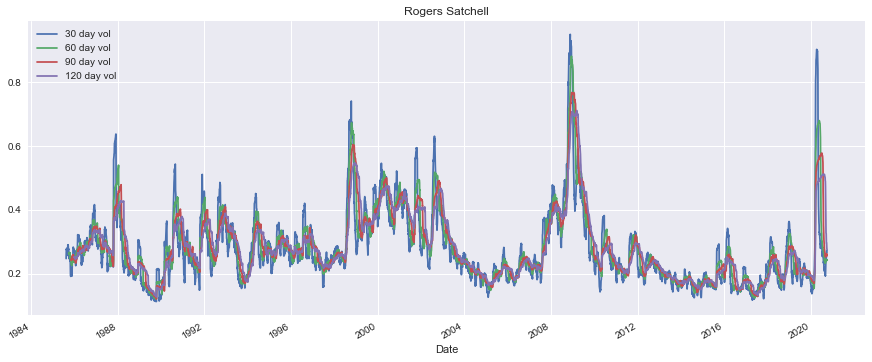

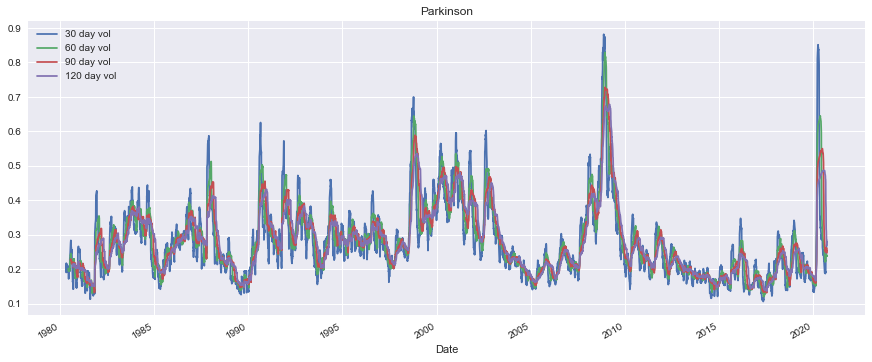

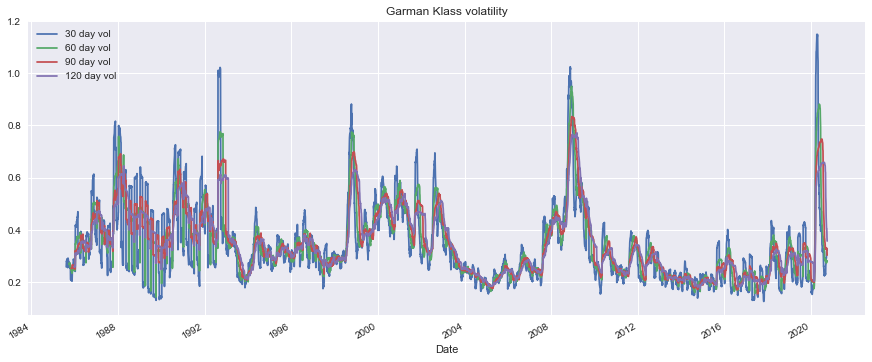

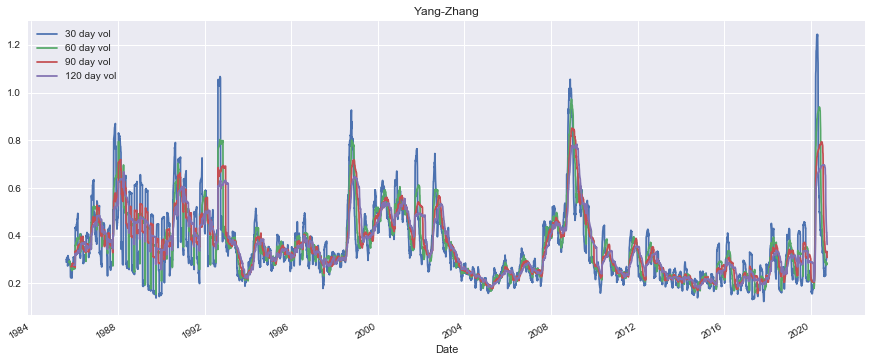

In [16]:
graph_create(df)

In [17]:
def report(df):
    ht = ht_f(df)
    rs = rs_f(df)
    yz = yz_f(df)
    gk = gk_f(df)
    pk = pk_f(df)
    
    ht_cones = ht.copy()
    ht_cones = ht_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]] 
    rs_cones = rs.copy()
    rs_cones = rs_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    gk_cones = gk.copy()
    gk_cones = gk_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    pk_cones = pk.copy()
    pk_cones = pk_cones[["30 day vol","60 day vol","90 day vol","120 day vol"]]
    yz_cones = yz.copy()
    yz_cones = yz_cones[["30 Day Yang Zhang","60 Day Yang Zhang","90 Day Yang Zhang","120 Day Yang Zhang"]]
    yz_cones.columns =["30 day vol","60 day vol","90 day vol","120 day vol"]
    
    times= [30,60,90,120]
    tmp_strings = [str(t) + " day vol" for t in times]
    yz_est = [yz_cones[tmp_strings[i]][0] for i in range(len(tmp_strings))]
    gk_est = [gk_cones[tmp_strings[i]][0] for i in range(len(tmp_strings))]
    rs_est = [rs_cones[tmp_strings[i]][0] for i in range(len(tmp_strings))]
    pk_est = [pk_cones[tmp_strings[i]][0] for i in range(len(tmp_strings))]
    ht_est = [ht_cones[tmp_strings[i]][0] for i in range(len(tmp_strings))]
    summary = pd.DataFrame([yz_est, gk_est, rs_est, pk_est, ht_est], index = ["Yang-Zhang","Garman-Klass","Rogers-Satchell","Parkinson","Hode-Tompkins"], columns= tmp_strings)
    summary.loc["Average"] = summary.mean()
    summary = summary.multiply(100)
    garch_now = gh.iloc[0][0]
    print("The Garch estimate is {}".format(garch_now*100))
    display(summary)

In [18]:
report(df)

The Garch estimate is 32.70114500484997


,30 day vol,60 day vol,90 day vol,120 day vol
Yang-Zhang,33.376074,28.415163,30.891732,36.357314
Garman-Klass,32.677742,28.033894,30.334351,35.739022
Rogers-Satchell,27.291301,24.266012,25.546828,27.576544
Parkinson,28.006342,23.909501,24.738589,26.958598
Hode-Tompkins,33.047020,25.606428,27.177847,29.965624
Average,30.879696,26.046200,27.737869,31.319421


In [19]:
def yz_cones(df):
    yz = yz_f(df)
    yz_cones = yz.copy()
    yz_cones = yz_cones[["30 Day Yang Zhang","60 Day Yang Zhang","90 Day Yang Zhang","120 Day Yang Zhang"]]
    yz_cones.columns =["30 day vol","60 day vol","90 day vol","120 day vol"]
    yz_maxi =yz_cones.quantile(1)
    yz_quartile_3 =yz_cones.quantile(.75)
    yz_median = yz_cones.quantile()
    yz_quartile_1 =yz_cones.quantile(.25)
    yz_mini =yz_cones.quantile(0)
    yz_report = pd.DataFrame([yz_maxi, yz_quartile_3, yz_median, yz_quartile_1, yz_mini], index=["Max","Q3","Median","Q2","Min"])
    yz_report
    yz_report.transpose().plot(figsize=(15,6))
    plt.title("Yang-Zhang Cones")
    plt.show()


In [20]:
from scipy import stats

def stab(df):
    yz = yz_f(df)
    yz_cones = yz.copy()
    yz_cones = yz_cones[["30 Day Yang Zhang","60 Day Yang Zhang","90 Day Yang Zhang","120 Day Yang Zhang"]]
    yz_cones.columns =["30 day vol","60 day vol","90 day vol","120 day vol"]
    #select which cone
    numsearch = yz_cones.copy()
    #Current IV
    iv = .56 #pull from broker as a function of ticker 
    #inverse of quantile
    return stats.percentileofscore(numsearch['30 day vol'],iv) #iv as a function of ticker 
stab(df)

78.53648992369399

In [21]:
def scanner(sym):
    for x in sym:
        print('{} percentile is %.3f'.format(x) %stab(df_dict[x]))

In [22]:
options = list()
for x in sym:
    options.append([x,stab(df_dict[x])])
options.sort(key=lambda x: x[1], reverse=True)
options[:10]

NameError: name 'sym' is not defined

In [ ]:
#Greeks

# S: underlying stock price
# K: Option strike price
# r: risk free rate
# D: dividend value
# vol: Volatility
# T: time to expiry (assumed that we're measuring from t=0 to T)
from scipy.stats import norm

def d1_calc(S, K, r, vol, T, t):
    # Calculates d1 in the BSM equation
    return (np.log(S/K) + (r + 0.5 * vol**2)*(T-t))/(vol*np.sqrt(T-t))

def BS_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    return S * norm.cdf(d1) - K * np.exp(-r*T)*norm.cdf(d2)

def BS_put(S, K, r, vol, T, t):
    return BS_call(S, K, r, vol, T, t) - S + np.exp(-r*(T-t))*K

def BS_binary_call(S, K, r, vol, T, t):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    return np.exp(-r*T)*norm.cdf(d2)

def BS_binary_put(S, K, r, vol, T, t):
    return BS_binary_call(S, K, r, vol, T,t) - S + np.exp(-r*(T-t))*K

###########################################################################
#1st Order Greeks
def delta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t) 
    if(otype == "call"):
        delta = norm.cdf(d1)
    elif(otype == "put"):
        delta = -norm.cdf(-d1)
    return delta


def vega(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    return (S * norm.pdf(d1) * np.sqrt(T-t))/100

def rho(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    if(otype == "call"):
        rho = K*(T-t)*np.exp(-r*(T-t))*norm.cdf(d2)
    elif(otype == "put"):
        rho = -K*(T-t)*np.exp(-r*(T-t))*norm.cdf(-d2)
        
    return rho/100

def theta(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t) 
    if(otype == "call"):
        theta = ((S*norm.pdf(d1)*vol)/(2*np.sqrt(T-t))) - r*K*np.exp(-r*(T-t))*norm.cdf(d2)
    elif(otype == "put"):
        theta = -(S*norm.pdf(d1)*vol / (2*np.sqrt(T-t))) + r*K*np.exp(-r*(T-t))*norm.cdf(d2)
    return theta/365

def omega(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol * np.sqrt(T-t)
    
    if(otype == "call"):
        omega = (np.exp(-(T-t))*norm.cdf(d1))*(S/(BS_call(S, K, r, vol, T, t)))
    elif(otype == "put"):
        omega = -np.exp(-(T-t))*norm.cdf(-d1)*(S/(BS_put(S, K, r, vol, T, t)))

    return omega

#2nd Order Greeks
def gamma(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    gamma = (norm.pdf(d1)) / (S * vol * np.sqrt(T-t))
    
    return gamma

def charm(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    d2 = d1 - vol*np.sqrt(T-t)
    charm = -norm.pdf(d1)*(2*r*(T-t) - d2*vol*np.sqrt(T-t))/(2*(T-t)*vol*np.sqrt(T-t))

    return charm

def vanna(S, K, r, vol, T, t, otype):
    d1 = d1_calc(S, K, r, vol, T, t)
    return norm.pdf(d1) * np.sqrt(T-t) * (1-d1)



In [ ]:
theta(310.96,311,0,.0691,4/365,0,'call')

In [ ]:
# Zakamoulin

r = 0
lam =.02 #transaction cost IB
vol = 0.3
T = 1
t = 0
S=105
K = 100
low_gamma = 1 #absolute risk aversion  

def param_H_0(S, K, r, vol, T, t, otype):
    H_0 = lam/(low_gamma*S*(vol**2)*(T-t))
    return H_0


def param_H_w(S, K, r, vol, T, t, otype):
    H_w = 1.18*(((lam**0.31) * (T-t)**0.1)/((vol**0.25)*np.exp(0.15*(T-t)))) *((gamma(S, K, r, vol, T, t, otype)/low_gamma)**0.5)
    return H_w


def variance_modfied(S, K, r, vol, T, t, otype):
    var_m = vol**2*((1 + 6.85*((lam**0.78 * (T-t)**0.1)/(vol**0.25 *np.exp(0.2 * (T-t))))*(low_gamma*S*S*gamma(S, K, r, vol, T, t, otype))**0.15))
    return var_m

def upper_band(S, K, r, vol, T, t, otype):
    upper_b = delta(S, K, r,(np.sqrt(variance_modfied(S, K, r, vol, T, t, otype))), T, t, otype) + param_H_0(S, K, r, vol, T, t, otype) +param_H_w(S, K, r, vol, T, t, otype)
    return upper_b

def lower_band(S, K, r, vol, T, t, otype):
    lower_b = delta(S, K, r,(np.sqrt(variance_modfied(S, K, r, vol, T, t, otype))), T, t, otype) - param_H_0(S, K, r, vol, T, t, otype) -param_H_w(S, K, r, vol, T, t, otype)
    return lower_b

In [ ]:
u =[]
b=[]
d=[]
for x in range (K-80,K+81):
    up=upper_band(x, K, r, vol, T, t, "call")
    u.append(up)
    bott=lower_band(x, K, r, vol, T, t, "call")
    b.append(bott)
    dlt= delta(x, K, r, vol, T, t, "call")
    d.append(dlt)
u=np.array(u)
b=np.array(b)
d=np.array(d)

#df= pd.DataFrame(data=[u,b], index = [d])
df = pd.DataFrame({'Upper': u, 'Lower':b, 'Delta':d}, index = d)
df.index.name = "Delta"
df.plot(figsize=(15,6))
plt.title("Hedge-Bands")
plt.show()


In [ ]:
def wrap(func,args): # with star
    return func(*args)
p1= [209.68, 211, 0.022344, .5131, 10/365, 0,'call']
wrap(delta,p1)

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(40, 30))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Strike + Underlying', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')
vals = [15,25,35]

r = 0.01
vol = 0.25
T = 1
t = 0
plt.subplot(321)
for i in vals:
    tmp_c = [delta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [delta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Delta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Delta Put K=%i" % i ))

plt.ylabel("Delta")
plt.legend()

plt.subplot(322)
for i in vals:
    tmp_c = [gamma(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [gamma(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Gamma Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Gamma Put K=%i" % i ))

plt.ylabel("Gamma")
plt.legend()

plt.subplot(323)
for i in vals:
    tmp_c = [vega(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [vega(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Vega Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Vega Put K=%i" % i ))

plt.ylabel("Vega")
plt.legend()

plt.subplot(324)

for i in vals:
    tmp_c = [rho(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [rho(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Rho Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Rho Put K=%i" % i ))

plt.ylabel("Rho")
plt.legend()

plt.subplot(325)
for i in vals:
    tmp_c = [theta(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [theta(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Theta Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Theta Put K=%i" % i ))

plt.ylabel("Theta")
plt.legend()

plt.subplot(326)
for i in vals:
    tmp_c = [charm(s, i, r, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [charm(s, i, r, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Charm Call K=%i" % i ))
    plt.plot(tmp_p, label = ("Charm Put K=%i" % i ))

plt.ylabel("Charm")
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True, figsize=(30, 20))
fig.suptitle('Sensitivity of 1st Order European Option Greeks to Risk-Free Rate + Underlying', fontsize=20, fontweight='bold')
fig.text(0.5, 0.08, 'Stock/Underlying Price ($)', ha='center', fontsize=18, fontweight='bold')

vals = [0,0.01,0.1]
K = 15
r = 0.01
vol = 0.1
T = 10
t = 0
plt.subplot(321)
for i in vals:
    tmp_c = [delta(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [delta(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Delta Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Delta Put r=%.2f" % i ))

plt.ylabel("Delta")
plt.legend()

plt.subplot(322)
for i in vals:
    tmp_c = [gamma(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [gamma(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Gamma Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Gamma Put r=%.2f" % i ))

plt.ylabel("Gamma")
plt.legend()

plt.subplot(323)
for i in vals:
    tmp_c = [vega(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [vega(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Vega Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Vega Put r=%.2f" % i ))

plt.ylabel("Vega")
plt.legend()

plt.subplot(324)

for i in vals:
    tmp_c = [rho(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [rho(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Rho Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Rho Put r=%.2f" % i ))

plt.ylabel("Rho")
plt.legend()

plt.subplot(325)
for i in vals:
    tmp_c = [theta(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [theta(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Theta Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Theta Put r=%.2f" % i ))

plt.ylabel("Theta")
plt.legend()

plt.subplot(326)
for i in vals:
    tmp_c = [charm(s, K, i, vol, T, t, "call") for s in np.arange(1,100)]
    tmp_p = [charm(s, K, i, vol, T, t, "put") for s in np.arange(1,100)]
    plt.plot(tmp_c, label = ("Charm Call r=%.2f" % i ))
    plt.plot(tmp_p, label = ("Charm Put r=%.2f" % i ))

plt.ylabel("Charm")
plt.legend()
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


# greek_function: input the function we want to calculate over
# x_var_name: 1st variable we vary
# y_var_name: 2nd variable we vary
# S: vector of underlying prices
# K: vector of strike prices
# r: vector of risk free rates
# vol: vector of volatilities
# T: vector of expiry
# t: vector of current date
# x: meshgrid of 1st variable we vary
# y: meshgrid of 2nd variable we vary
# otype: put/call
# plot: plot figure we want to write to
def greeks_plot_tool(greek_function, x_var_name, y_var_name,
                    S, K, r, vol, T, t, x, y, otype, plot):
   
    # Initialise vector to store our option values and then iterate over
    # Assumption that we're using a constant sized vector length for each variable
    # Need to change the variables being iterated over here for each update (possibly a better way to do this)
    V = np.zeros((len(S), len(S)), dtype=np.float)
    for i in range(len(S)):
        for j in range(len(S)):
            V[i, j] = greek_function(S[i], K[i], r[i], vol[i], T[j], t[i], otype)
 
    # Initiliase plotting canvas

    surf = plot.plot_surface(x, y, V, rstride=1, cstride=1,alpha=0.75,cmap=cm.RdYlBu)
    plot.set_xlabel('\n' + x_var_name, linespacing=4)
    plot.set_ylabel('\n' + y_var_name, linespacing=4)
    plot.set_zlabel("%s(K, T)" % greek_function.__name__)
    plot.set_title("%s %s" % (otype, greek_function.__name__))
    
    # Calculate colour levels based on our meshgrid
    Vlevels = np.linspace(V.min(),V.max(),num=8,endpoint=True)
    xlevels = np.linspace(x.min(),x.max(),num=8,endpoint=True)
    ylevels = np.linspace(y.min(),y.max(),num=8,endpoint=True)
    
    cset = plot.contourf(x, y, V, Vlevels, zdir='z',offset=V.min(),
                       cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, xlevels, zdir='x',offset=x.min(),
                       cmap=cm.RdYlBu,linestyles='dashed')
    cset = plot.contourf(x, y, V, ylevels, zdir='y',offset=y.max(),
                       cmap=cm.RdYlBu,linestyles='dashed')

    # Set our viewing constraints
    for c in cset.collections:
        c.set_dashes([(0, (2.0, 2.0))]) # Dash contours

    plt.clabel(cset,fontsize=10, inline=1)
    plot.set_xlim(x.min(),x.max())
    plot.set_ylim(y.min(),y.max())
    plot.set_zlim(V.min(),V.max())

    # Colorbar
    colbar = plt.colorbar(surf, shrink=1.0, extend='both', aspect = 10)
    l,b,w,h = plt.gca().get_position().bounds
    ll,bb,ww,hh = colbar.ax.get_position().bounds
    colbar.ax.set_position([ll, b+0.1*h, ww, h*0.8])
    
        
S = np.linspace(70, 140, 40)
K = np.linspace(105.0, 105.0, 40)
T = np.linspace(0.1, 2.0, 40)
t = np.linspace(0.0, 0.0, 40)
r = np.linspace(0.0, 0.0, 40)
vol = np.linspace(0.12, 0.12, 40)

x, y  = np.meshgrid(S, T)

fig = plt.figure(figsize=(30,20))
fig.suptitle("Greek Sensitivities to Stock Price and Expiry",fontsize=20, fontweight='bold')
greeks = [delta, gamma, vega, charm]

for i in range(len(greeks)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    greeks_plot_tool(greeks[i],"Stock Price", "Expiry", S, K, r, vol, T, t, x, y, "call", ax)

plt.show()


In [ ]:
#skew

skew = df.copy()
    
skew["log_return"] = (skew['Adj Close'] / skew['Adj Close'].shift(-1)).apply(np.log)
skew["30 day skew"] = skew["log_return"].rolling(window=30).skew().shift(-29)
skew["60 day skew"] = skew["log_return"].rolling(window=60).skew().shift(-59)
skew["90 day skew"] = skew["log_return"].rolling(window=90).skew().shift(-89)
skew["120 day skew"] = skew["log_return"].rolling(window=120).skew().shift(-119)
skew_cones = skew.copy()
skew_cones = skew_cones[["30 day skew","60 day skew","90 day skew","120 day skew"]]

In [ ]:
skew_maxi =skew_cones.quantile(1)
skew_quartile_3 =skew_cones.quantile(.75)
skew_median = skew_cones.quantile()
skew_quartile_1 =skew_cones.quantile(.25)
skew_mini =skew_cones.quantile(0)
skew_report = pd.DataFrame([skew_maxi, skew_quartile_3, skew_median, skew_quartile_1, skew_mini], index=["Max","Q3","Median","Q2","Min"])
skew_report

In [ ]:
skew_report.transpose().plot(figsize=(15,6))
plt.title("Skew")
plt.show()

In [ ]:
#kurt

kurt = df.copy()
    
kurt["log_return"] = (kurt['Adj Close'] / kurt['Adj Close'].shift(-1)).apply(np.log)
kurt["30 day kurt"] = kurt["log_return"].rolling(window=30).kurt().shift(-29)
kurt["60 day kurt"] = kurt["log_return"].rolling(window=60).kurt().shift(-59)
kurt["90 day kurt"] = kurt["log_return"].rolling(window=90).kurt().shift(-89)
kurt["120 day kurt"] = kurt["log_return"].rolling(window=120).kurt().shift(-119)
kurt_cones = kurt.copy()
kurt_cones = kurt_cones[["30 day kurt","60 day kurt","90 day kurt","120 day kurt"]]


In [ ]:
kurt_maxi =kurt_cones.quantile(1)
kurt_quartile_3 =kurt_cones.quantile(.75)
kurt_median = kurt_cones.quantile()
kurt_quartile_1 =kurt_cones.quantile(.25)
kurt_mini =kurt_cones.quantile(0)
kurt_report = pd.DataFrame([kurt_maxi, kurt_quartile_3, kurt_median, kurt_quartile_1, kurt_mini], index=["Max","Q3","Median","Q2","Min"])
kurt_report


In [ ]:
kurt_report.transpose().plot(figsize=(15,6))
plt.title("Kurtosis")
plt.show()